In [1]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *

In [2]:
from lookahead import LookaheadAdam

In [3]:
def fit_with_annealing(learn:Learner, num_epoch:int, lr:float=defaults.lr, annealing_start:float=0.5)->None:
    
    n = len(learn.data.train_dl)
    anneal_start = int(n*num_epoch*annealing_start)
    
    
    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr)
    phase1 = TrainingPhase(n*num_epoch - anneal_start).schedule_hp('lr', lr, anneal=annealing_cos)

    phases = [phase0, phase1]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    learn.fit(num_epoch)

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)
learn = Learner(data, simple_cnn((3,16,16,2)), opt_func=partial(LookaheadAdam, betas=(0.9,0.99), eps=1e-6), \
                metrics=[accuracy, error_rate])

In [5]:
fit_with_annealing(learn, 4, 3e-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.067921,0.045499,0.982826,0.017174,00:03
1,0.037140,0.021980,0.993131,0.006869,00:03
2,0.027962,0.022483,0.989205,0.010795,00:03
3,0.014839,0.016076,0.992149,0.007851,00:03


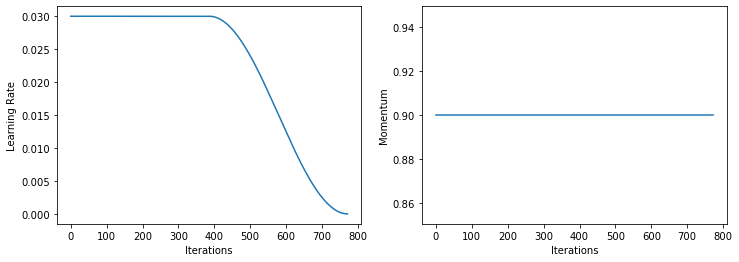

In [6]:
learn.recorder.plot_lr(show_moms=True)